# SPLEEN samples integration

# (pre and post processing)

# OD1, OD2, OD4 + HS1 & HS2

In [1]:
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')

import os, sys, math, re
import natsort, json, operator, getpass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import scanpy as sc
import scanpy.external as sce

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets

# to deal with those pesky non-persistent widget plots
import base64
from io import BytesIO
from IPython.display import HTML

In [2]:
with open('/.singularity.d/labels.json') as fh:
    singularity = json.load(fh)
    
singularity['Version']

'metztli.25j'

In [3]:
sc.settings.verbosity = 3             # show some output
sc.settings.file_format_figs = 'svg'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.settings.savefigs = False

In [4]:
home = str(Path.home())
user = getpass.getuser()

In [5]:
"""
Allows to create a persistent png image from
the last plotted matplotlib plot widget
"""
def perma_plot():
    # TODO: maybe pass parameters for savefig
    #       to control quality/type of img
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    
    encoded_string = base64.b64encode(buffer.read()).decode('utf-8')
    html_string = '<img src=\'data:image/png;base64,{}\'>'.format(encoded_string)
    
    return html_string

---

In [6]:
basedir = os.path.join(home, 'databoard/users', user, '2021/BloodPaper/')

sc.settings.writedir = os.path.join(basedir, 'h5ad/')

---

## 2021-11-02

---

In [7]:
now = datetime.now()
prefix = now.strftime('%Y%m%d')
print(prefix)

20211102


**COMBO10**

In [8]:
reference = sc.read('20211102_COMBO10_annotated_reference_filtered_and_clean')

In [9]:
reference

AnnData object with n_obs × n_vars = 117200 × 24332
    obs: 'batch', 'n_counts', 'n_genes', 'library', 'donor', 'organ', 'leiden.1.2', 'annot', 'silhouette.1.2', 'is_root', 'dpt_pseudotime', 'dpt_pseudotime_rank', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annot_colors', 'dex_leiden_1_2', 'diffmap_evals', 'donor_colors', 'draw_graph', 'hvg', 'iroot', 'leiden', 'leiden.1.2_colors', 'log1p', 'neighbors', 'phase_colors'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    layers: 'counts', 'lognorm'
    obsp: 'connectivities', 'distances'

Subset to just SPL cells for ref

In [11]:
ref = reference[reference.obs.organ.isin(['SPL']), :].copy()
ref.shape

(22068, 24332)

In [12]:
ref.X.min(), ref.X.max()

(0.0, 8.784979)

---

### 2x SPL samples (SLX21128)

---

In [14]:
fetch1 = os.path.join(home, 'databoard/users', user, '2021/SLX21128/h5ad/')

In [15]:
target = sc.read( os.path.join(fetch1, '20211026_SLX21128_SPL_CD19neg_CD34pos_HVG_DR_leiden') )

In [16]:
target

AnnData object with n_obs × n_vars = 9939 × 22955
    obs: 'library', 'organ', 'batch', 'doublet_scores', 'barcode', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'cluster0', 'cluster1', 'genotype', 'n_counts', 'n_counts_log', 'n_genes', 'percent_mitoc', 'leiden.1.0'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'genotype_colors', 'hvg', 'leiden', 'leiden.1.0_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_3D'
    varm: 'PCs'
    layers: 'counts', 'lognorm', 'regressed'
    obsp: 'connectivities', 'distances'

Set target's X as the lognormed data

In [17]:
target.X.min(), target.X.max()

(-15.332227, 99.6845)

In [18]:
target.X = target.layers['lognorm'].copy()

In [19]:
target.X.min(), target.X.max()

(0.0, 12.327681)

In [26]:
target.obs.apply( lambda x: 'SPL_' + x.genotype, axis=1 )

AAACCCAAGAGCATTA-1-1    SPL_1
AAACCCAAGATGGTAT-1-1    SPL_0
AAACCCAAGGCCCAAA-1-1    SPL_1
AAACCCACACCAGTTA-1-1    SPL_1
AAACCCATCATCACCC-1-1    SPL_0
                        ...  
TTTGTTGGTCAGGTAG-1-1    SPL_1
TTTGTTGTCAAGCTTG-1-1    SPL_1
TTTGTTGTCACTTGGA-1-1    SPL_1
TTTGTTGTCCTTCTGG-1-1    SPL_1
TTTGTTGTCGGTAAGG-1-1    SPL_0
Length: 9939, dtype: object

In [27]:
target.obs['donor'] = target.obs.apply( lambda x: 'SPL_' + x.genotype, axis=1 )

In [22]:
target.obs.columns

Index(['library', 'organ', 'batch', 'doublet_scores', 'barcode', 'status',
       'assignment', 'log_prob_singleton', 'log_prob_doublet', 'cluster0',
       'cluster1', 'genotype', 'n_counts', 'n_counts_log', 'n_genes',
       'percent_mitoc', 'leiden.1.0', 'donor'],
      dtype='object')

In [23]:
ref.obs.columns

Index(['batch', 'n_counts', 'n_genes', 'library', 'donor', 'organ',
       'leiden.1.2', 'annot', 'silhouette.1.2', 'is_root', 'dpt_pseudotime',
       'dpt_pseudotime_rank', 'S_score', 'G2M_score', 'phase'],
      dtype='object')

In [28]:
ref.X = ref.layers['counts'].copy()

target.X = target.layers['counts'].copy()

In [29]:
ref.shape, target.shape

((22068, 24332), (9939, 22955))

In [30]:
combo_spleen = ref.concatenate(target, batch_key='dataset', batch_categories=['ref', 'target'], index_unique=None)

In [31]:
combo_spleen

AnnData object with n_obs × n_vars = 32007 × 22423
    obs: 'batch', 'n_counts', 'n_genes', 'library', 'donor', 'organ', 'leiden.1.2', 'annot', 'silhouette.1.2', 'is_root', 'dpt_pseudotime', 'dpt_pseudotime_rank', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'barcode', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'cluster0', 'cluster1', 'genotype', 'n_counts_log', 'percent_mitoc', 'leiden.1.0', 'dataset'
    var: 'gene_ids', 'n_cells-ref', 'highly_variable-ref', 'means-ref', 'dispersions-ref', 'dispersions_norm-ref', 'n_cells-target', 'highly_variable-target', 'means-target', 'dispersions-target', 'dispersions_norm-target', 'feature_types-target', 'genome-target', 'mean-target', 'std-target'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'lognorm'

In [34]:
sex_linked = ['RPS4Y1','NACA2','RPL10L','TIPIN','ZNF90','UQCRHL','DDX3Y','EIF1AY',
              'MIF-AS1','ATP5L2','GREM1','EDARADD','AC009501.4','NBEAL1','MTRNR2L12',
              'FKBP1C','AC090498.1','NHSL2','LRRC69','MTRNR2L8','HNRNPA1L2','PABPC3',
              'RP11-302B13.5','RP5-940J5.9','EIF5AL','XIST']

In [35]:
combo_spleen = combo_spleen[:, [x for x in combo_spleen.var.index if x not in sex_linked]].copy()

In [38]:
combo_spleen.obs.columns

Index(['batch', 'n_counts', 'n_genes', 'library', 'donor', 'organ',
       'leiden.1.2', 'annot', 'silhouette.1.2', 'is_root', 'dpt_pseudotime',
       'dpt_pseudotime_rank', 'S_score', 'G2M_score', 'phase',
       'doublet_scores', 'barcode', 'status', 'assignment',
       'log_prob_singleton', 'log_prob_doublet', 'cluster0', 'cluster1',
       'genotype', 'n_counts_log', 'percent_mitoc', 'leiden.1.0', 'dataset'],
      dtype='object')

In [50]:
anno = {'0' : '00_HSC/MPP2',
       '1' : '01_LyP2',
       '2' : '02_MEP2',
       '3' : '03_LyP3',
       '4' : '04_HSC/MPP1',
       '5' : '05_HSC/MPP3',
       '6' : '06_MyP1',
       '7' : '07_MPP-to-CMP',
       '8' : '08_EryP',
       '9' : '09_MyP2',
       '10' : '10_MPP-to-MEP',
       '11' : '11_HSC/MPP4',
       '12' : '12_MEP1',
       '13' : '13_MEP cycle',
       '14' : '14_ND',
       '15' : '15_MyP4 (GMP)',
       '16' : '16_MyP3 (cycle)',
       '17' : '17_EoBasoMCP',
       '18' : '18_LyP1',
       '19' : '19_HSPC cycle',
       '21' : '21_HSC/MPP5',
       '22' : '22_MkP',
       '23' : '23_EryP/MyP mix',
       '24' : '24_MDP'}

In [54]:
combo_spleen.obs[['dataset', 'library', 'donor', 'leiden.1.2']]

,dataset,library,donor,leiden.1.2
_01_AAACCTGCACTGTTAG.1.3,ref,SIGAG9,DOD1,0
_01_AAACCTGCAGGGAGAG.1.3,ref,SIGAG9,DOD1,6
_01_AAACCTGGTTATTCTC.1.3,ref,SIGAG9,DOD1,3
_01_AAACGGGAGGCCCTTG.1.3,ref,SIGAG9,DOD1,12
_01_AAACGGGGTCGCCATG.1.3,ref,SIGAG9,DOD1,6
...,...,...,...,...
TTTGTTGGTCAGGTAG-1-1,target,SITTB8,SPL_1,NaN
TTTGTTGTCAAGCTTG-1-1,target,SITTB8,SPL_1,NaN
TTTGTTGTCACTTGGA-1-1,target,SITTB8,SPL_1,NaN
TTTGTTGTCCTTCTGG-1-1,target,SITTB8,SPL_1,NaN


In [55]:
meta = combo_spleen.obs[['library', 'donor', 'leiden.1.2']].copy()

In [56]:
meta['annot'] = [anno[x]  if x in anno.keys() else 'unassigned' for x in meta.loc[:,'leiden.1.2']  ]
meta['annot'] = pd.Series(meta['annot'], dtype = 'category')

In [57]:
meta

,library,donor,leiden.1.2,annot
_01_AAACCTGCACTGTTAG.1.3,SIGAG9,DOD1,0,00_HSC/MPP2
_01_AAACCTGCAGGGAGAG.1.3,SIGAG9,DOD1,6,06_MyP1
_01_AAACCTGGTTATTCTC.1.3,SIGAG9,DOD1,3,03_LyP3
_01_AAACGGGAGGCCCTTG.1.3,SIGAG9,DOD1,12,12_MEP1
_01_AAACGGGGTCGCCATG.1.3,SIGAG9,DOD1,6,06_MyP1
...,...,...,...,...
TTTGTTGGTCAGGTAG-1-1,SITTB8,SPL_1,NaN,unassigned
TTTGTTGTCAAGCTTG-1-1,SITTB8,SPL_1,NaN,unassigned
TTTGTTGTCACTTGGA-1-1,SITTB8,SPL_1,NaN,unassigned
TTTGTTGTCCTTCTGG-1-1,SITTB8,SPL_1,NaN,unassigned


In [59]:
meta.to_csv('output/'+prefix+'_COMBO_SPLEEN_filtered_metadata.txt', sep='\t')

In [61]:
%%time

udf = pd.DataFrame( combo_spleen[:, combo_spleen.var.index].X.toarray().T , 
                      index=list(combo_spleen.var.index), 
                      columns=list(combo_spleen.obs.index) )

udf.to_csv( os.path.join(sc.settings.writedir, '..', 
                           'matrices', prefix+'_COMBO_SPLEEN_filtered_gene_x_cells_XFILTERED_matrix.txt.gz'),
                           sep='\t', quotechar='"')

CPU times: user 22min 12s, sys: 46.6 s, total: 22min 58s
Wall time: 23min 1s


In [62]:
combo_spleen.shape

(32007, 22402)

In [63]:
meta.shape

(32007, 4)

---

---

### Continued on nb ``09d2_R_...`` and then returned here to process its results

---

---

In [64]:
integrated = sc.read('20211102_COMBO_SPLEEN_Seurat_VST_classic_integration_processed_minimal')

In [65]:
integrated

AnnData object with n_obs × n_vars = 32007 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor', 'library', 'leiden.1.2', 'annot'
    var: 'features'

In [66]:
integrated.var

,features
MPO,MPO
HBB,HBB
HBD,HBD
CA1,CA1
APOC1,APOC1
...,...
AK5,AK5
SFPQ,SFPQ
RPS3,RPS3
AIG1,AIG1


In [67]:
integrated.X.min(), integrated.X.max()

(-3.237878751444848, 6.628049543155244)

In [70]:
integrated.layers['seurat'] = integrated.X.copy()

In [71]:
sc.pp.scale(integrated)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [72]:
integrated.X.min(), integrated.X.max()

(-21.807854107633354, 132.6479280811855)

In [73]:
sc.tl.pca(integrated, n_comps=30)

computing PCA
    with n_comps=30
    finished (0:00:10)


In [74]:
sc.pl.embedding(integrated, basis='pca', color=['donor'])

... storing 'orig.ident' as categorical
... storing 'donor' as categorical
... storing 'library' as categorical
... storing 'annot' as categorical


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [76]:
plt.subplots_adjust(right=.8)


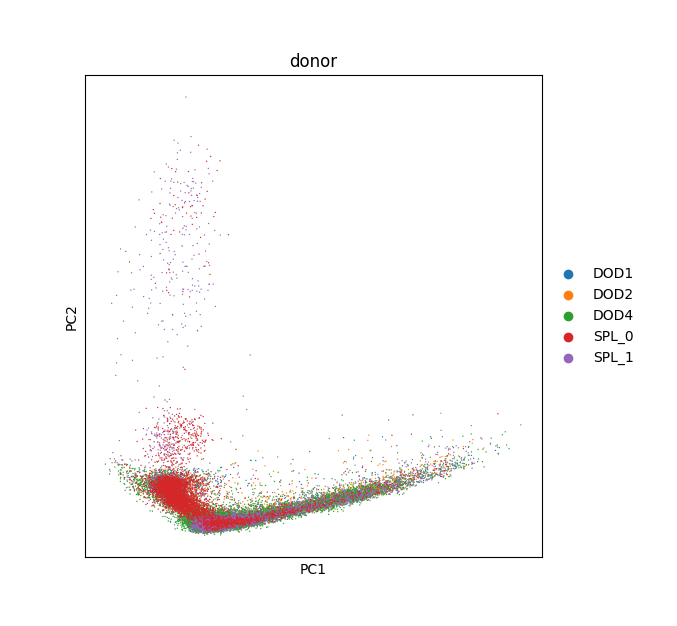

In [77]:
HTML(perma_plot())

In [78]:
integrated

AnnData object with n_obs × n_vars = 32007 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor', 'library', 'leiden.1.2', 'annot'
    var: 'features', 'mean', 'std'
    uns: 'pca', 'donor_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'seurat'

In [79]:
integrated.uns['pca']

{'params': {'zero_center': True, 'use_highly_variable': False},
 'variance': array([100.21045687,  47.12385024,  41.86478936,  30.91612905,
         24.70928662,  18.99915911,  15.65109659,  12.08078303,
         10.29990863,   9.46125792,   8.19168237,   7.81448174,
          6.90462104,   5.89178964,   5.14179116,   4.98883094,
          4.74038792,   4.33222061,   4.07473268,   3.88849597,
          3.71321402,   3.60087223,   3.44156832,   3.14144154,
          3.03426322,   2.88357575,   2.86460917,   2.80052805,
          2.7612496 ,   2.63230902]),
 'variance_ratio': array([0.05010523, 0.02356193, 0.02093239, 0.01545806, 0.01235464,
        0.00949958, 0.00782555, 0.00604039, 0.00514995, 0.00473063,
        0.00409584, 0.00390724, 0.00345231, 0.00294589, 0.0025709 ,
        0.00249442, 0.00237019, 0.00216611, 0.00203737, 0.00194425,
        0.00185661, 0.00180044, 0.00172078, 0.00157072, 0.00151713,
        0.00144179, 0.0014323 , 0.00140026, 0.00138062, 0.00131615])}

In [80]:
sc.pp.neighbors(integrated)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [81]:
integrated

AnnData object with n_obs × n_vars = 32007 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor', 'library', 'leiden.1.2', 'annot'
    var: 'features', 'mean', 'std'
    uns: 'pca', 'donor_colors', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'seurat'
    obsp: 'distances', 'connectivities'

In [82]:
sc.tl.umap(integrated)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


In [83]:
sc.pl.embedding(integrated, basis='umap', color='donor')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [84]:
plt.subplots_adjust(right=.8)


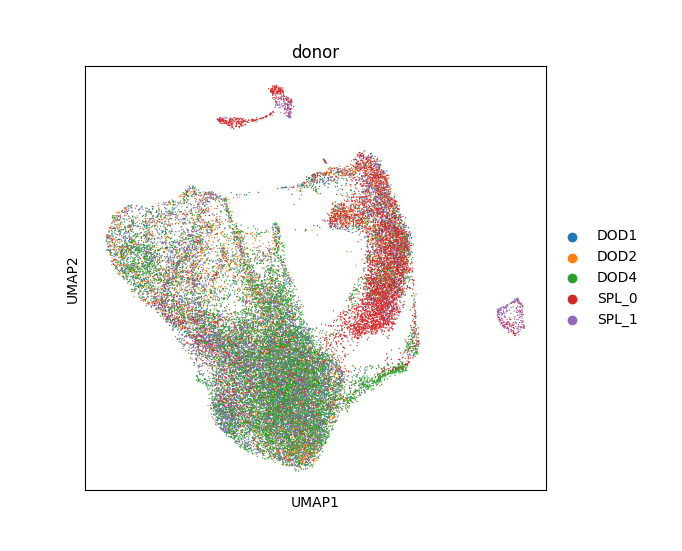

In [85]:
HTML(perma_plot())

In [101]:
%%time
sc.write(prefix+'_COMBO_SPLEEN_Seurat_VST_classic_integration_Scanpy_downstream_processed_basic', integrated)

CPU times: user 27.8 s, sys: 1.42 s, total: 29.2 s
Wall time: 29 s


In [102]:
integrated

AnnData object with n_obs × n_vars = 32007 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor', 'library', 'leiden.1.2', 'annot'
    var: 'features', 'mean', 'std'
    uns: 'pca', 'donor_colors', 'neighbors', 'umap', 'annot_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'seurat'
    obsp: 'distances', 'connectivities'